In [41]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ssvep_analyzer import SsvepAnalyzer

from scipy.signal import cwt, morlet2

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [33]:
def read_file(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, severity

def preprocess_data(eeg_data):
    analyzer = SsvepAnalyzer(sampling_rate=250, stimulus_frequency=16.5)
    eeg_data = analyzer.filter_extreme_values(eeg_data)
    eeg_data = analyzer.apply_linear_detrending(eeg_data)
    eeg_data = analyzer.apply_lowpass_filter(eeg_data)
    eeg_data = analyzer.apply_highpass_filter(eeg_data)
    eeg_data = analyzer.apply_notch_filter(eeg_data)
    reduced_eeg_data, _ = analyzer.compute_reduced_signal(eeg_data)
    return reduced_eeg_data

def build_dataset(directory_list):
    X = []
    y = []
    for directory in directory_list:
        for file in os.listdir('../Data/' + directory):
            file_path = '../Data/' + directory + '/' + file
            eeg_data, severity = read_file(file_path)
            reduced_eeg_data = preprocess_data(eeg_data)
            X.append(np.concatenate((reduced_eeg_data, np.zeros(6200 - len(reduced_eeg_data))))) # zero padding
            y.append(severity)
    return np.array(X), np.array(y)

directory_list = ['2024-01-06']

X, y = build_dataset(directory_list)

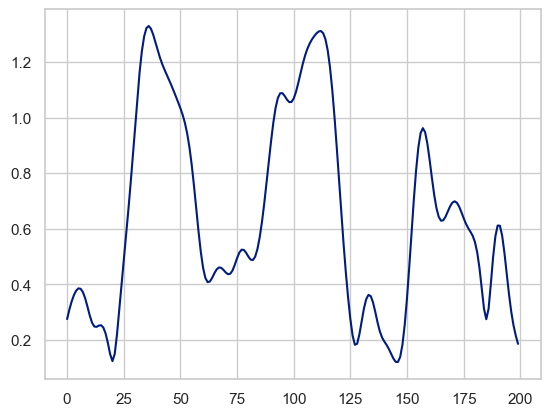

[3.91757082e-01 1.55743696e-01 1.40398705e-01 6.50781961e-02
 5.43300162e-02 4.74073532e-02 3.31311641e-02 2.74473598e-02
 2.08640456e-02 1.62713416e-02 9.80259448e-03 8.93546843e-03
 6.83095332e-03 5.23902858e-03 4.44916474e-03 3.26625500e-03
 1.93349269e-03 1.39926826e-03 1.26245882e-03 1.07040794e-03
 8.57458393e-04 6.31377096e-04 5.47594590e-04 3.36985710e-04
 2.58738535e-04 2.12286573e-04 1.44626291e-04 1.18951192e-04
 1.07945709e-04 5.86554248e-05 4.65338369e-05 3.58763665e-05
 1.48441680e-05 1.00744646e-05 1.69470132e-32]


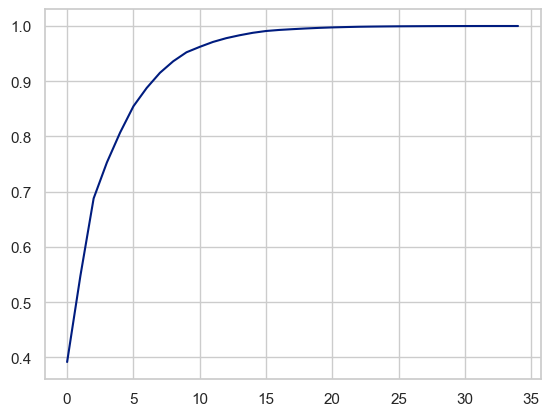

In [34]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, w=50, n_samples=200, sampling_rate=250, frequency=16.5):
        self.w = w
        self.n_samples = n_samples
        self.sampling_rate = sampling_rate
        self.frequency = frequency

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        width = self.w * self.sampling_rate / (2 * np.pi * self.frequency)
        cwt_matrix = np.apply_along_axis(lambda x: np.abs(cwt(x, morlet2, widths=[width], w=self.w, dtype='complex128')).flatten(), axis=1, arr=X)
        idx_mask = cwt_matrix.shape[1] // self.n_samples * np.arange(self.n_samples)
        cwt_matrix = cwt_matrix[:, idx_mask]
        return cwt_matrix

wavelet_transformer = WaveletTransformer()
pca = PCA()

X_fit = wavelet_transformer.fit_transform(X)
plt.plot(X_fit[0])
plt.show()
X_pca = pca.fit_transform(X_fit)
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.5)

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w=50, n_samples=200)),
    ('pca', PCA(n_components=7)),
    ('kernel_ridge', KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1))
])

pipeline = pipeline.fit(X_train, y_train)

In [52]:
y_pred = pipeline.predict(X_test)
R2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
print(R2)

-0.5289356334312552
